Pre-Processing

In [ ]:
# Note: refer to https://www.kaggle.com/discussions/general/74235

from google.colab import files
files.upload()  # Upload kaggle.json here

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset
!unzip -o face-expression-recognition-dataset.zip -d face_expression_dataset

Streaming output truncated to the last 5000 lines.
  inflating: face_expression_dataset/images/validation/fear/8797.jpg  
  inflating: face_expression_dataset/images/validation/fear/8818.jpg  
  inflating: face_expression_dataset/images/validation/fear/886.jpg  
  inflating: face_expression_dataset/images/validation/fear/9037.jpg  
  inflating: face_expression_dataset/images/validation/fear/9040.jpg  
  inflating: face_expression_dataset/images/validation/fear/9101.jpg  
  inflating: face_expression_dataset/images/validation/fear/911.jpg  
  inflating: face_expression_dataset/images/validation/fear/9179.jpg  
  inflating: face_expression_dataset/images/validation/fear/9205.jpg  
  inflating: face_expression_dataset/images/validation/fear/9232.jpg  
  inflating: face_expression_dataset/images/validation/fear/9251.jpg  
  inflating: face_expression_dataset/images/validation/fear/9261.jpg  
  inflating: face_expression_dataset/images/validation/fear/9281.jpg  
  inflating: face_expression

In [ ]:
# Install required packages if not already installed
!pip install torch torchvision --quiet
!pip install grad-cam

import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy.signal import convolve2d
import torch.nn as nn




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 105.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.t

In [ ]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),    # Convert to 3 channels
    transforms.Resize((224, 224)),                  # Resize to MobileNetV2 input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])


In [ ]:
train_dir="/content/face_expression_dataset/images/train"
val_dir="/content/face_expression_dataset/images/validation"
#data directories defined

In [ ]:
train_dataset=datasets.ImageFolder(root=train_dir,transform=transform)
val_dataset=datasets.ImageFolder(root=val_dir,transform=transform)
#created datasets here

In [ ]:
train_loader=DataLoader(train_dataset,batch_size=64,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=64,shuffle=False)
#shuffles the training data at the start,improve generalization
#keep validation untouched

In [ ]:
# Added code block to add transform
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [ ]:
images,labels=next(iter(train_loader)) #check one batch
print("Check Image batch shape:",images.shape)
print("Label batch shape:",labels.shape)
print("First label in batch:",labels[0])

Check Image batch shape: torch.Size([64, 3, 224, 224])
Label batch shape: torch.Size([64])
First label in batch: tensor(3)


In [ ]:
print("Total training samples:",len(train_dataset))
print("Total validation samples:",len(val_dataset))
print("Class to index mapping:",train_dataset.class_to_idx)

Total training samples: 28821
Total validation samples: 7066
Class to index mapping: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


Model Def

In [ ]:
# Class representing a full cnn layer

class cnn_layer:
  def __init__(self, input_size = 48, num_kernels = 16, kernel_size = 2, padding = 'valid'):
    """
    Initializes the cnn layer
    Parameters:
      input_size: size of input images so that input image is input_size x input_size
      num_kernels: number of kernels/filters
      kernel_size: size of kernels so that kernels have shape kernel_size x kernel_size
      padding: a string. If padding = 'valid', then no padding. If padding = 'same', then include padding
    """
    # initialize attributes
    self.input_size = input_size
    self.num_kernels = num_kernels
    self.kernel_size = kernel_size
    self.padding = padding
    if padding == 'valid':
      self.output_size = input_size - kernel_size + 1
    if padding == 'same':
      self.output_size = input_size

    # create list of num_kernels-many arrays of size kernel_size x kernel_size
    # initialized with standard normal distribution
    self.kernels = [np.random.randn(kernel_size, kernel_size) for i in range(num_kernels)]
    self.biases = [np.random.randn(self.output_size, self.output_size) for i in range(num_kernels)]

  def set_weights(self, w):
    """
    Tunes the weights of the kernels
    Parameters:
      w: a numpy array of size (num_kernels*kernel_size^2, )
    """
    if w.shape != (self.num_kernels*self.kernel_size**2,):
      print(f'w must be of shape ({self.num_kernels*self.kernel_size**2}, )')
    else:
      self.kernels = [sub_arr for sub_arr in w.reshape(self.num_kernels, self.kernel_size, self.kernel_size)]

  def forward(self, image):
    """
    Returns a list where each element in the list is a numpy array obtained by
    convolving image with each kernel in self.kernels
    Parameters:
      image: a numpy array of shape (48,48,1)
    """
    if self.padding == 'valid':
      L = [np.expand_dims(convolve2d(image.squeeze(), kernel, mode = 'valid'), axis = -1) for kernel in self.kernels]
    elif self.padding == 'same':
      L = [np.expand_dims(convolve2d(image.squeeze(), kernel, mode = 'same'), axis = -1) for kernel in self.kernels]
    return L

In [ ]:
# Class representing dense layer at the end used for classification

class dense_layer:
  def __init__(self, input_size, output_size, activation = 'relu'):
    """
    Initializes the dense layer
    Parameters:
      input_size: size of input array, i.e. number of features
      output_size: size of output, i.e. number of units in the layer
      activation: string of name of activation function.
                  Can be 'relu', 'sigmoid', 'softmax', 'tanh', 'identity'
    """
    # initialize attributes
    self.input_size = input_size
    self.output_size = output_size
    self.activation = activation

    # initialize weights of edges with standard normal
    # Note: w_{ji} is weight of edge from z_i in previous layer to a_j in current layer
    self.weights = np.random.standard_normal((input_size, output_size))
    self.bias = np.random.standard_normal((output_size))

  def set_weights(self, w, b):
    """
    Tunes the weights of the dense layer
    Parameters:
      w: a numpy array of shape (input_size*output_size, )
    """
    if w.shape != (self.input_size, self.output_size,):
      print(f'w must be of shape ({self.input_size}, {self.output_size})')
    else:
      self.weights = w

    if b.shape != (self.output_size):
      print(f'b must be of shape ({self.output_size}, )')
    else:
      self.bias = b

  def forward(self, input):
    """
    Performs matrix multiplication self.weights @ input
    Returns a vector of shape (output_size, )
    Parameters:
      input: a numpy array of size (self.input_size, )
    """
    a = self.weights @ input + self.bias

    if self.activation == None or self.activation == 'identity':
      return a
    if self.activation == 'relu':
      return np.maximum(0, a)
    if self.activation == 'sigmoid':
      return 1/(1 + np.exp(-a))
    if self.activation == 'softmax':
      e_x = np.exp(a - np.max(a))
      return e_x/e_x.sum()
    if self.activation == 'tanh':
      return np.tanh(a)

Housekeeping and seeds, using GPU instead of CPU

In [ ]:
import torch, random, numpy as np
torch.manual_seed(42); np.random.seed(42); random.seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using', device)

Using cuda


Loading Pretrained MobileNetV2

In [ ]:

# Load model structure
model = mobilenet_v2(weights='DEFAULT')

# Freeze most layers
for p in model.parameters():
    p.requires_grad = False

# Unfreeze last few layers for Grad-CAM compatibility
for name, p in model.named_parameters():
    if any(layer in name for layer in ['features.14', 'features.15', 'features.16', 'features.17']):
        p.requires_grad = True

# Replace classifier head for 7-class emotion task
in_f = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_f, 7)

# Wrap in Sequential if needed (like your training code did)
model = nn.Sequential(nn.Identity(), model).to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 96.8MB/s]


In [ ]:
from torchvision.models import mobilenet_v2
import torch.nn as nn
import time

# Model setup
model = mobilenet_v2(weights='DEFAULT')
for p in model.parameters():
    p.requires_grad = False
for name, p in model.named_parameters():
    if any(layer in name for layer in ['features.14', 'features.15', 'features.16', 'features.17']):
        p.requires_grad = True
in_f = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_f, 7)
model = nn.Sequential(nn.Identity(), model).to(device)
mobilenet = model  # Use consistent variable

# Training setup
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, mobilenet.parameters()),
                              lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15)

train_losses, val_losses, val_accuracies = [], [], []
best_acc = 0

for epoch in range(1, 16):
    start = time.time()
    mobilenet.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = mobilenet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation
    mobilenet.eval()
    correct, total, val_loss = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = mobilenet(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = correct / total
    train_losses.append(total_loss)
    val_losses.append(val_loss)
    val_accuracies.append(acc)
    scheduler.step()

    print(f"Epoch {epoch:02d} | Train Loss: {total_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {acc:.2%} | Time: {time.time() - start:.2f}s")

    if acc > best_acc:
        best_acc = acc
        torch.save(mobilenet.state_dict(), "mobile_best.pth")

# Load best model for evaluation or Grad-CAM
mobilenet.load_state_dict(torch.load("mobile_best.pth"))

Epoch 01 | Train Loss: 654.2607 | Val Loss: 143.5818 | Val Acc: 58.28% | Time: 141.99s
Epoch 02 | Train Loss: 540.3631 | Val Loss: 140.4131 | Val Acc: 60.19% | Time: 119.83s
Epoch 03 | Train Loss: 461.0626 | Val Loss: 141.4165 | Val Acc: 60.85% | Time: 120.62s
Epoch 04 | Train Loss: 373.7602 | Val Loss: 150.6563 | Val Acc: 59.89% | Time: 120.37s
Epoch 05 | Train Loss: 302.3821 | Val Loss: 155.3448 | Val Acc: 60.23% | Time: 121.05s
Epoch 06 | Train Loss: 262.7765 | Val Loss: 157.8450 | Val Acc: 60.71% | Time: 119.55s
Epoch 07 | Train Loss: 244.0296 | Val Loss: 158.8612 | Val Acc: 60.47% | Time: 119.17s
Epoch 08 | Train Loss: 233.7448 | Val Loss: 157.4549 | Val Acc: 60.76% | Time: 119.96s
Epoch 09 | Train Loss: 227.9561 | Val Loss: 154.6001 | Val Acc: 61.38% | Time: 118.13s
Epoch 10 | Train Loss: 224.2121 | Val Loss: 153.5662 | Val Acc: 60.70% | Time: 118.61s
Epoch 11 | Train Loss: 221.7070 | Val Loss: 152.5467 | Val Acc: 61.02% | Time: 118.37s
Epoch 12 | Train Loss: 219.4869 | Val Loss:

<All keys matched successfully>

In [ ]:
torch.save(mobilenet.state_dict(), "mobilenet_model.pth")

In [ ]:
from torchvision.models import mobilenet_v2
import torch.nn as nn

# Rebuild the same architecture
model = mobilenet_v2(weights='DEFAULT')
for p in model.parameters():
    p.requires_grad = False
for name, p in model.named_parameters():
    if any(layer in name for layer in ['features.14', 'features.15', 'features.16', 'features.17']):
        p.requires_grad = True
in_f = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_f, 7)

# Match the training structure (wrapped with Identity)
model = nn.Sequential(nn.Identity(), model).to(device)

# Load trained weights
model.load_state_dict(torch.load("mobile_best.pth", map_location=device))
model.eval()


Sequential(
  (0): Identity()
  (1): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, ker

Checking Time

Epoch 1 took 0.00 seconds
Epoch 2 took 0.00 seconds
Epoch 3 took 0.00 seconds
Epoch 4 took 0.00 seconds
Epoch 5 took 0.00 seconds
Epoch 6 took 0.00 seconds
Epoch 7 took 0.00 seconds
Epoch 8 took 0.00 seconds
Epoch 9 took 0.00 seconds
Epoch 10 took 0.00 seconds


GradCAM

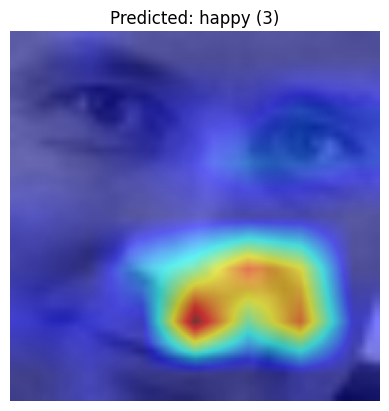

In [ ]:
from PIL import Image
import cv2
import numpy as np
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import matplotlib.pyplot as plt

# Load and prepare image
img_path = "face_expression_dataset/images/validation/happy/10019.jpg"
img = cv2.imread(img_path)
if img is None:
    raise FileNotFoundError(f"Could not read image at {img_path}")

# Preprocess for Grad-CAM
img = cv2.resize(img, (224, 224))
rgb_img = img[..., ::-1]  # BGR to RGB
rgb_img_normalized = rgb_img.astype(np.float32) / 255.0

# Apply same transform used in training
input_tensor = transform(Image.fromarray(rgb_img)).unsqueeze(0).to(device)

# Predict class
model.eval()
with torch.no_grad():
    output = model(input_tensor)
    predicted_class_index = output.argmax().item()

# Grad-CAM setup — fix this line:
target_layers = [model[1].features[-1]]  # ← correct for wrapped model
cam = GradCAM(model=model, target_layers=target_layers)
targets = [ClassifierOutputTarget(predicted_class_index)]

# Generate Grad-CAM mask
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

# Overlay heatmap
visualization = show_cam_on_image(rgb_img_normalized, grayscale_cam, use_rgb=True)

# Optional: get label name
idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}
predicted_class_name = idx_to_class[predicted_class_index]

# Display
plt.imshow(visualization)
plt.axis('off')
plt.title(f"Predicted: {predicted_class_name} ({predicted_class_index})")
plt.show()


Testing GradCAM on dataset

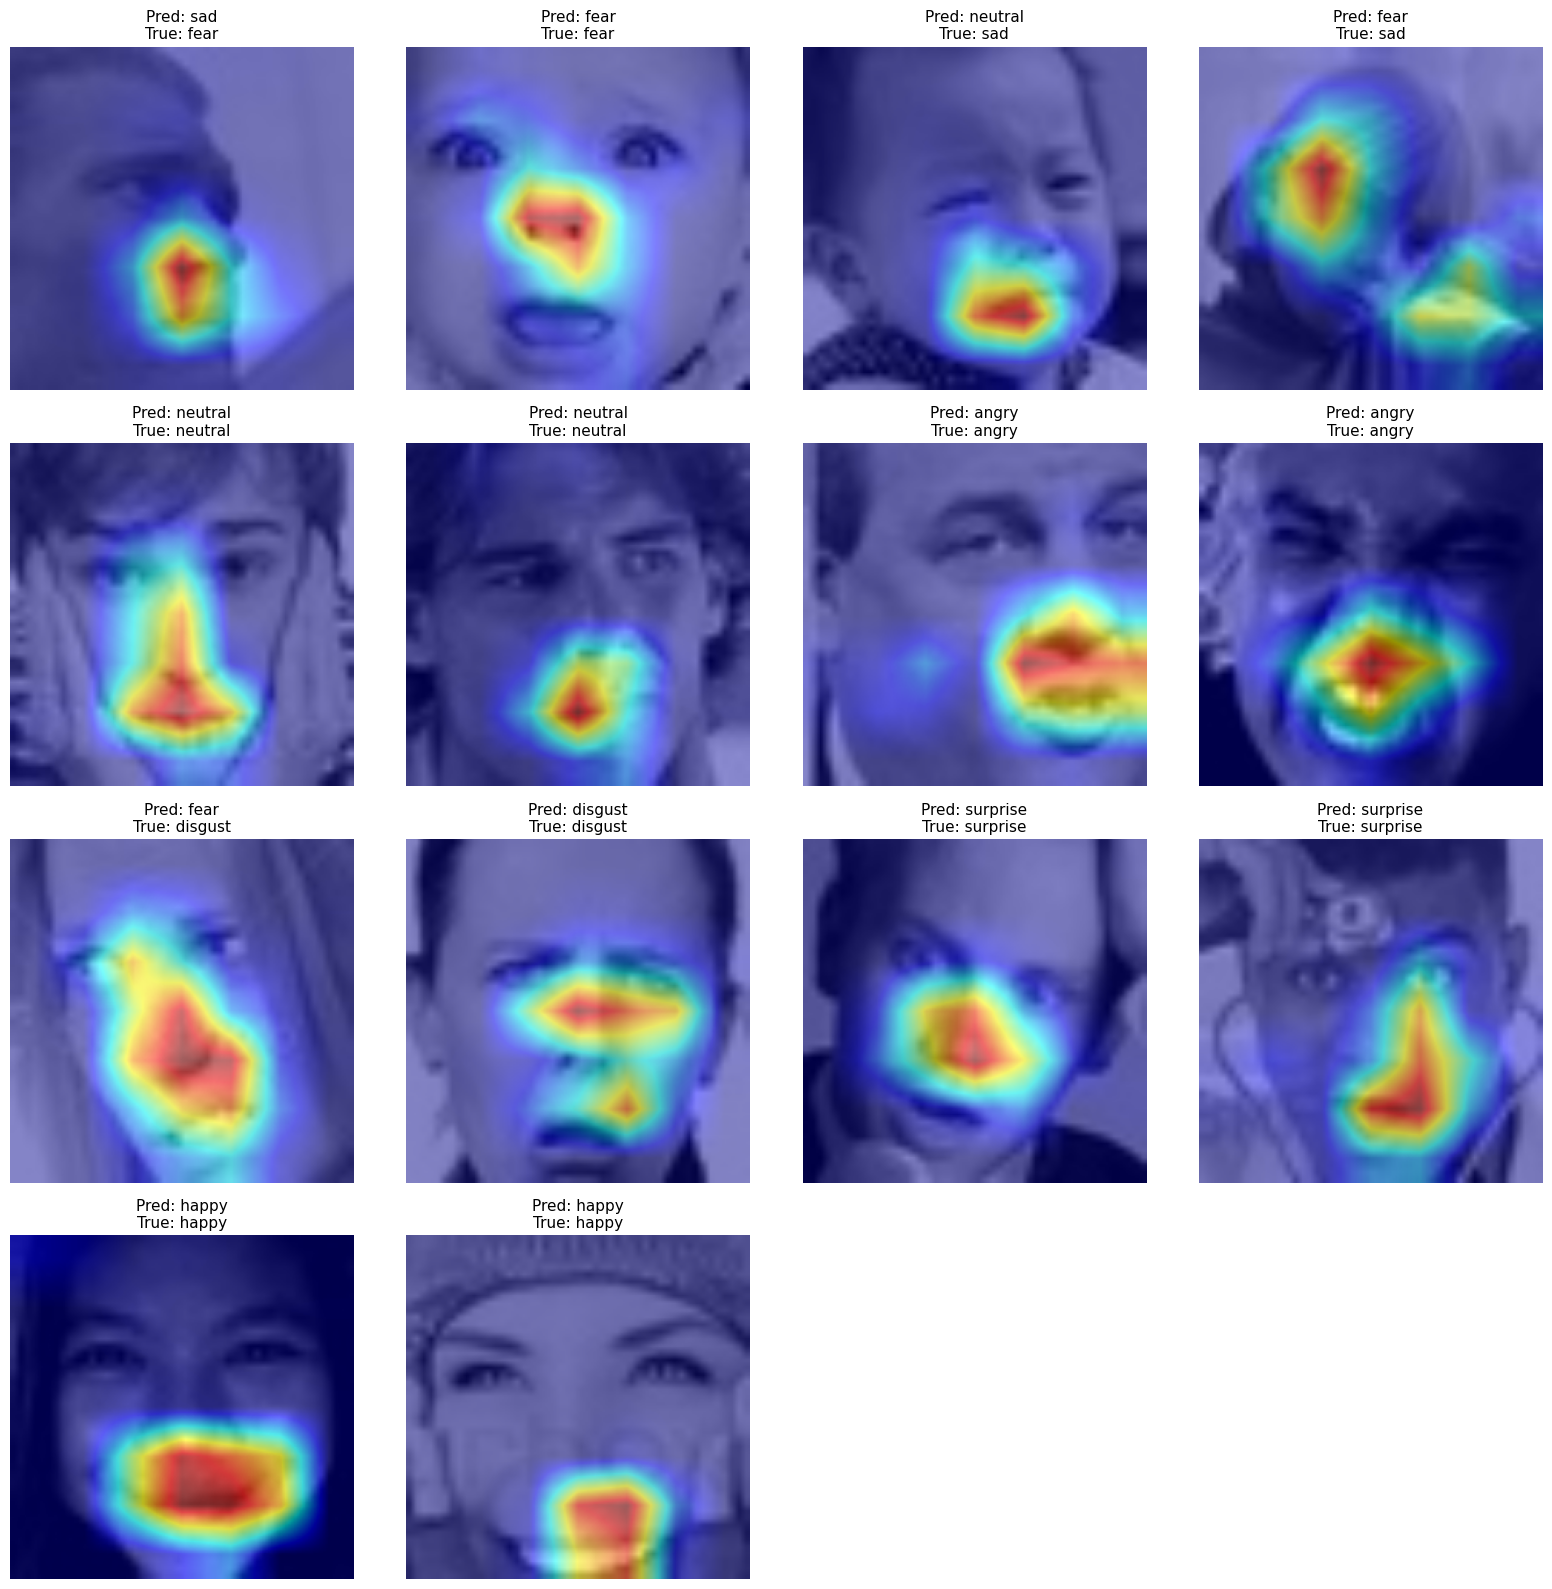

In [ ]:
from PIL import Image
import cv2
import numpy as np
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import matplotlib.pyplot as plt
import os
import random

# Invert class_to_idx to map prediction index to label
idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}

# Get a few random image paths from validation set
val_root = "face_expression_dataset/images/validation"
image_paths = []

for emotion_class in os.listdir(val_root):
    class_path = os.path.join(val_root, emotion_class)
    if os.path.isdir(class_path):
        sample_files = random.sample(os.listdir(class_path), min(2, len(os.listdir(class_path))))
        for file in sample_files:
            image_paths.append(os.path.join(class_path, file))

# Initialize Grad-CAM
target_layers = [model[1].features[-1]]
cam = GradCAM(model=model, target_layers=target_layers)

# Set up figure
n = len(image_paths)
cols = 4
rows = (n + cols - 1) // cols
plt.figure(figsize=(16, 4 * rows))

# Process each image
for i, img_path in enumerate(image_paths):
    img = cv2.imread(img_path)
    if img is None:
        continue

    img = cv2.resize(img, (224, 224))
    rgb_img = img[..., ::-1]
    rgb_img_normalized = rgb_img.astype(np.float32) / 255.0
    input_tensor = transform(Image.fromarray(rgb_img)).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        predicted_index = output.argmax().item()
        predicted_label = idx_to_class[predicted_index]

    grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(predicted_index)])[0]
    visualization = show_cam_on_image(rgb_img_normalized, grayscale_cam, use_rgb=True)

    plt.subplot(rows, cols, i + 1)
    plt.imshow(visualization)
    # Get true label from folder name
    true_label = os.path.basename(os.path.dirname(img_path))

    # Display predicted vs actual
    plt.title(f"Pred: {predicted_label}\nTrue: {true_label}", fontsize=11)

    plt.axis("off")

plt.tight_layout()
plt.savefig("gradcam_examples.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
from google.colab import files
files.download("gradcam_examples.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>